In [99]:
from functions import *
from haversine import haversine, Unit
import pickle

In [100]:
s1_stack = get_stack()

intensity = np.abs(s1_stack.complex.values)**2

intensity_mean_space = np.mean(intensity, axis=(0,1))
intensity_median_space = np.median(intensity, axis=(0,1))

mean_space_db = 10*np.log10(np.abs(intensity_mean_space) / np.abs(intensity_mean_space).max())
median_space_db = 10*np.log10(np.abs(intensity_median_space) / np.abs(intensity_median_space).max())

# remove bad epochs

bad_is = []

for i in range(len(mean_space_db)):
    mean_val = mean_space_db[i]
    median_val = median_space_db[i]

    if mean_val > (np.mean(mean_space_db) + 1 * np.std(mean_space_db)):
        bad_is.append(i)
    elif mean_val < (np.mean(mean_space_db) - 1 * np.std(mean_space_db)):
        bad_is.append(i)
    elif median_val > (np.mean(median_space_db) + 1 * np.std(median_space_db)):
        bad_is.append(i)

s1_stack = drop_isel(s1_stack, bad_is, 'time')



In [101]:
lat_gnss_station = 53.13637817
lon_gnss_station = 6.44928672 

Da, Da_cal = compute_amplitude_dispersion(s1_stack)
points_around_gnss = find_points_within_polygon(s1_stack.lat.values, s1_stack.lon.values, lat_gnss_station, lon_gnss_station, 0.01)
Da_cal_min, idx_cal_min = get_minimum_da(Da_cal, points_around_gnss)

In [102]:
haversine((s1_stack.lat.values[idx_cal_min], s1_stack.lon.values[idx_cal_min]), (lat_gnss_station, lon_gnss_station), unit=Unit.METERS)

In [103]:
list_of_gradient_threshold = [10]
list_of_Da_threshold = [0.5]

As = np.zeros((len(list_of_Da_threshold), len(list_of_gradient_threshold)), dtype=object)
ls_phase_arr_preprocesseds = np.zeros((len(list_of_Da_threshold), len(list_of_gradient_threshold)), dtype=object)
arc_phase_uw_preprocesseds = np.zeros((len(list_of_Da_threshold), len(list_of_gradient_threshold)), dtype=object)
points_preprocesseds = np.zeros((len(list_of_Da_threshold), len(list_of_gradient_threshold)), dtype=object)
arcs_preprocesseds = np.zeros((len(list_of_Da_threshold), len(list_of_gradient_threshold)), dtype=object)

for j, Da_threshold in enumerate(list_of_Da_threshold):
    print(f"Processing Da threshold {Da_threshold}.")
    for i, gradient_threshold in enumerate(list_of_gradient_threshold):
        print(f"Processing gradient threshold {gradient_threshold}.")

        arcs_preprocessed, points_preprocessed, arc_phase_uw_preprocessed, best_ind_preprocessed = preprocess(Da_cal, Da_cal_min, s1_stack, Da_threshold, gradient_threshold, verbose=False)
        A, ls_phase_arr_preprocessed = compute_uw_phase_network(arcs_preprocessed, points_preprocessed, arc_phase_uw_preprocessed, best_ind_preprocessed)
        As[j, i] = A
        ls_phase_arr_preprocesseds[j, i] = ls_phase_arr_preprocessed
        arc_phase_uw_preprocesseds[j, i] = arc_phase_uw_preprocessed
        points_preprocesseds[j, i] = points_preprocessed
        arcs_preprocesseds[j, i] = arcs_preprocessed

arcs_no_preprocess, points_no_preprocess = compute_delaunay_arcs(Da_cal, Da_threshold, s1_stack, idx_cal_min, preprocessing=False)

slc_points_no_preprocess, Da_points_no_preprocess = get_slc_and_Da_points(arcs_no_preprocess, points_no_preprocess, s1_stack, Da_cal)
best_ind = np.where(Da_points_no_preprocess == Da_cal_min)[0][0]

arc_phase_uw_no_preprocess = compute_arc_phase_uw(slc_points_no_preprocess, best_ind, arcs_no_preprocess)


A_no_preprocess, ls_phase_arr_no_preprocess = compute_uw_phase_network(arcs_no_preprocess, points_no_preprocess, arc_phase_uw_no_preprocess, best_ind)

In [104]:
slc_to_delete = np.where(compute_MSE(As[j,i], ls_phase_arr_preprocesseds[j,i], arc_phase_uw_preprocesseds[j,i]) > 0.05)[0]

In [105]:
s1_stack = drop_isel(s1_stack, slc_to_delete, 'time')


In [106]:
As = np.zeros((len(list_of_Da_threshold), len(list_of_gradient_threshold)), dtype=object)
ls_phase_arr_preprocesseds = np.zeros((len(list_of_Da_threshold), len(list_of_gradient_threshold)), dtype=object)
arc_phase_uw_preprocesseds = np.zeros((len(list_of_Da_threshold), len(list_of_gradient_threshold)), dtype=object)
points_preprocesseds = np.zeros((len(list_of_Da_threshold), len(list_of_gradient_threshold)), dtype=object)
arcs_preprocesseds = np.zeros((len(list_of_Da_threshold), len(list_of_gradient_threshold)), dtype=object)

for j, Da_threshold in enumerate(list_of_Da_threshold):
    print(f"Processing Da threshold {Da_threshold}.")
    for i, gradient_threshold in enumerate(list_of_gradient_threshold):
        print(f"Processing gradient threshold {gradient_threshold}.")

        arcs_preprocessed, points_preprocessed, arc_phase_uw_preprocessed, best_ind_preprocessed = preprocess(Da_cal, Da_cal_min, s1_stack, Da_threshold, gradient_threshold, verbose=False)
        A, ls_phase_arr_preprocessed = compute_uw_phase_network(arcs_preprocessed, points_preprocessed, arc_phase_uw_preprocessed, best_ind_preprocessed)
        As[j, i] = A
        ls_phase_arr_preprocesseds[j, i] = ls_phase_arr_preprocessed
        arc_phase_uw_preprocesseds[j, i] = arc_phase_uw_preprocessed
        points_preprocesseds[j, i] = points_preprocessed
        arcs_preprocesseds[j, i] = arcs_preprocessed
# 

In [107]:
print(slc_to_delete)

In [108]:

arcs_no_preprocess, points_no_preprocess = compute_delaunay_arcs(Da_cal, Da_threshold, s1_stack, idx_cal_min, preprocessing=False)

slc_points_no_preprocess, Da_points_no_preprocess = get_slc_and_Da_points(arcs_no_preprocess, points_no_preprocess, s1_stack, Da_cal)
best_ind = np.where(Da_points_no_preprocess == Da_cal_min)[0][0]

arc_phase_uw_no_preprocess = compute_arc_phase_uw(slc_points_no_preprocess, best_ind, arcs_no_preprocess)

A_no_preprocess, ls_phase_arr_no_preprocess = compute_uw_phase_network(arcs_no_preprocess, points_no_preprocess, arc_phase_uw_no_preprocess, best_ind)
mse_no_preprocess = compute_MSE(A_no_preprocess, ls_phase_arr_no_preprocess, arc_phase_uw_no_preprocess)    


In [53]:
with open('s1_stack.pkl', 'wb') as f:
    pickle.dump(s1_stack, f)

with open('As_preprocessed.pkl', 'wb') as f:
    pickle.dump(As, f)

with open('ls_phase_arr_preprocesseds.pkl', 'wb') as f:
    pickle.dump(ls_phase_arr_preprocesseds, f)

with open('arc_phase_uw_preprocesseds.pkl', 'wb') as f:
    pickle.dump(arc_phase_uw_preprocesseds, f)

with open('points_preprocesseds.pkl', 'wb') as f:
    pickle.dump(points_preprocesseds, f)

with open('arcs_preprocesseds.pkl', 'wb') as f:
    pickle.dump(arcs_preprocesseds, f)




with open('A_no_preprocess.pkl', 'wb') as f:
    pickle.dump(A_no_preprocess, f)

with open('ls_phase_arr_no_preprocess.pkl', 'wb') as f:
    pickle.dump(ls_phase_arr_no_preprocess, f)

with open('arc_phase_uw_no_preprocess.pkl', 'wb') as f:
    pickle.dump(arc_phase_uw_no_preprocess, f)

with open("points_no_preprocess.pkl", 'wb') as f:
    pickle.dump(points_no_preprocess, f)

with open("arcs_no_preprocess.pkl", 'wb') as f:
    pickle.dump(arcs_no_preprocess, f)



In [129]:
import pickle
import matplotlib.pyplot as plt


with open('As_preprocessed_best.pkl', 'rb') as f:
    As = pickle.load(f)

with open('ls_phase_arr_preprocesseds_best.pkl', 'rb') as f:
    ls_phase_arr_preprocesseds = pickle.load(f)

with open('arc_phase_uw_preprocesseds_best.pkl', 'rb') as f:
    arc_phase_uw_preprocesseds = pickle.load(f)

with open('points_preprocesseds_best.pkl', 'rb') as f:
    points_preprocesseds = pickle.load(f)

with open('s1_stack_best.pkl', 'rb') as f:
    s1_stack = pickle.load(f)

with open('arcs_preprocesseds_best.pkl', 'rb') as f:
    arcs_preprocesseds = pickle.load(f)

with open('A_no_preprocess.pkl', 'rb') as f:
    A_no_preprocess = pickle.load(f)

with open('ls_phase_arr_no_preprocess.pkl', 'rb') as f:
    ls_phase_arr_no_preprocess = pickle.load(f)

with open('arc_phase_uw_no_preprocess.pkl', 'rb') as f:
    arc_phase_uw_no_preprocess = pickle.load(f)

with open("points_no_preprocess.pkl", 'rb') as f:
    points_no_preprocess = pickle.load(f)

with open("arcs_no_preprocess.pkl", 'rb') as f:
    arcs_no_preprocess = pickle.load(f)


In [128]:
A = As[0][0]
ls_phase_prep = ls_phase_arr_preprocesseds[0][0]
arc_phase_uw_prep = arc_phase_uw_preprocesseds[0][0]
points = points_preprocesseds[0][0]

A_no_prep = A_no_preprocess
ls_phase_no_prep = ls_phase_arr_no_preprocess

s1_stack.time.values.shape, A.shape, ls_phase_prep.shape, arc_phase_uw_prep.shape, points.shape, A_no_prep.shape, ls_phase_no_prep.shape

In [127]:
import pickle
import matplotlib.pyplot as plt


with open('As_preprocessed_best.pkl', 'rb') as f:
    As = pickle.load(f)

with open('ls_phase_arr_preprocesseds_best.pkl', 'rb') as f:
    ls_phase_arr_preprocesseds = pickle.load(f)

with open('arc_phase_uw_preprocesseds_best.pkl', 'rb') as f:
    arc_phase_uw_preprocesseds = pickle.load(f)

with open('points_preprocesseds_best.pkl', 'rb') as f:
    points_preprocesseds = pickle.load(f)

with open('s1_stack_best.pkl', 'rb') as f:
    s1_stack = pickle.load(f)

with open('arcs_preprocesseds_best.pkl', 'rb') as f:
    arcs_preprocesseds = pickle.load(f)

with open('A_no_preprocess.pkl', 'rb') as f:
    A_no_preprocess = pickle.load(f)

with open('ls_phase_arr_no_preprocess.pkl', 'rb') as f:
    ls_phase_arr_no_preprocess = pickle.load(f)

with open('arc_phase_uw_no_preprocess.pkl', 'rb') as f:
    arc_phase_uw_no_preprocess = pickle.load(f)

with open("points_no_preprocess.pkl", 'rb') as f:
    points_no_preprocess = pickle.load(f)

with open("arcs_no_preprocess.pkl", 'rb') as f:
    arcs_no_preprocess = pickle.load(f)

with open("s1_stack_best.pkl", 'rb') as f:
    s1_stack = pickle.load(f)


list_of_Da_threshold = [0.5]
list_of_gradient_threshold = [5]

markers = ['.', 'x', 'v', 's', '^']
colors = ['r', 'g', 'b', 'y', 'k', 'm']

plt.figure()
for j, Da_threshold in enumerate(list_of_Da_threshold):
    for i, gradient_threshold in enumerate(list_of_gradient_threshold):
        plt.plot(s1_stack.time.values[:-1], compute_MSE(As[j,i], ls_phase_arr_preprocesseds[j,i], 
                                                        arc_phase_uw_preprocesseds[j,i]), 
                                                        marker=markers[i], color = colors[j], 
                                                        linewidth=1,
                                                        label=f"Preprocessed {len(points_preprocesseds[j, i])} points, gradient threshold {gradient_threshold} and Da_threshold = {Da_threshold}.")
        
plt.plot(s1_stack.time.values[:-2], compute_MSE(A_no_preprocess, ls_phase_arr_no_preprocess, arc_phase_uw_no_preprocess), marker=markers[-1], color=colors[-1], label=f"No preprocess {len(points_no_preprocess)} points and Da_threshold = {Da_threshold}", linewidth=1)

plt.ylabel("MSE")
# plt.ylim(0,0.5)
plt.legend()
plt.xticks(rotation=45)
plt.savefig("MSE_preprocessed_vs_no_preprocessed.png")
plt.show()
plt.close()

In [22]:
def convert_to_decimal_year(dates):
    """
    Convert numpy datetime64 array to decimal years.

    Args:
    dates (numpy.ndarray): Array of dates in datetime64[D] format.

    Returns:
    numpy.ndarray: Array of dates in decimal years.
    """
    years = dates.astype('datetime64[Y]').astype(int) + 1970
    start_of_year = dates.astype('datetime64[Y]')
    day_of_year = (dates - start_of_year).astype('timedelta64[D]').astype(int) + 1
    days_in_year = np.where((years % 4 == 0) & (years % 100 != 0) | (years % 400 == 0), 366, 365)
    decimal_years = years + day_of_year / days_in_year
    return decimal_years

decimal_years = convert_to_decimal_year(s1_stack.time.values)

In [ ]:
ls_deformation = compute_los_deformation_from_phase(ls_phase_arr_preprocessed)

In [132]:
import pickle

with open("store_xhat.pkl", 'rb') as f:
    xhat = pickle.load(f)

with open("points_preprocesseds_best.pkl", 'rb') as f:
    points = pickle.load(f)

In [133]:
xhat.shape

# 0- intersect
# 1- trend
# 2- seasonal param one
# 3- seasonal param two

(784, 4)

In [134]:
points = points[0][0]

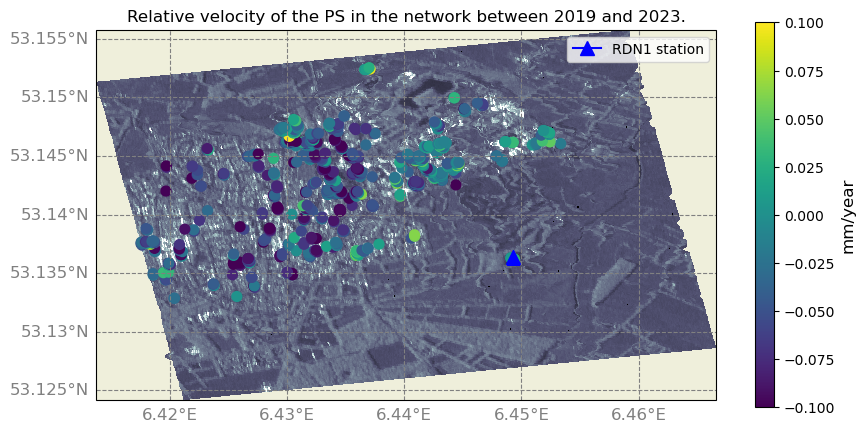

In [140]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10))
int_tmpavg = np.mean(np.abs(s1_stack.complex.values)**2,axis=2)
mean0 = np.mean(int_tmpavg)
std0 = np.std(int_tmpavg)
mesh = ax.pcolormesh(s1_stack.lon, s1_stack.lat, int_tmpavg**0.25, transform=ccrs.PlateCarree(), 
                    cmap='bone', vmax=(mean0+1*std0)**0.25)

ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12, 'color': 'gray'}
gl.ylabel_style = {'size': 12, 'color': 'gray'}

ax.plot(lon_gnss_station, lat_gnss_station, marker='^', color='blue', markersize=10, transform=ccrs.PlateCarree(), label='RDN1 station')

# for i, p in enumerate(points):
#     lat, lon = s1_stack.lat.values[p[0], p[1]], s1_stack.lon.values[p[0], p[1]]
#     ax.plot(lon, lat, marker='o', color='red', markersize=5, transform=ccrs.PlateCarree())


# Create color map for xhat[i][1] values
xhat_values = [xhat[i][1] for i in range(len(points))]
sc = ax.scatter(
    [s1_stack.lon.values[p[0], p[1]] for p in points],
    [s1_stack.lat.values[p[0], p[1]] for p in points],
    c=xhat_values, cmap='viridis', s=50, vmin=-0.1, vmax=0.1, transform=ccrs.PlateCarree()
)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('mm/year', fontsize=12)

plt.title("Relative velocity of the PS in the network between 2019 and 2023.")
plt.legend()
plt.savefig("figures/velocity_of_the_PS_in_the_network_between_2019_and_2023.png", dpi=300, bbox_inches='tight')

plt.show()

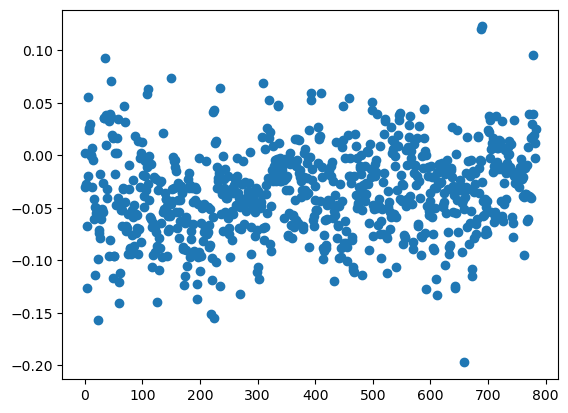

In [136]:
plt.scatter(np.arange(len(xhat[:,1])), xhat[:,1])